In [14]:
import cv2
import numpy as np

import sys
import io
import traceback
from tqdm import tqdm_notebook as tqdm

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import scipy.ndimage
import numpy as np
import os
from skimage.transform import resize

In [2]:
def get_img_from_fig(fig, dpi=180, output_height=829):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    width = int(img.shape[1] * output_height / img.shape[0])
    dim = (width, output_height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    return img

def get_plot_as_fig(idx, file_path, y_axis_name=""):
    data = np.load(file_path, allow_pickle=True)
    fig = plt.figure()
    tmp = plt.xlabel('Iteration')
    tmp = plt.ylabel(y_axis_name)
    #tmp = plt.xlim(0, len(data))
    tmp = plt.plot(data[:idx])
    plt.close()
    
    return get_img_from_fig(fig)

def extend_by_plots(img, idx, folder_name, to_height, filename):
    
    loss_plot   = get_plot_as_fig(idx, folder_name + "/loss_plot.npy", 'Loss')
    #latent_plot = get_plot_as_fig(idx, folder_name + "/latent_dist.npy", 'Distance in latent space')
    lr_plot     = get_plot_as_fig(idx, folder_name + "/lr_plot.npy", 'Latent Distance')
    
    z_img = cv2.cvtColor(cv2.imread( filename[:-4] + 'z' +  filename[-4:] ), cv2.COLOR_BGR2RGB)
    y_img = cv2.cvtColor(cv2.imread( filename[:-4] + 'y' +  filename[-4:] ), cv2.COLOR_BGR2RGB)
    
    dim = (loss_plot.shape[1], loss_plot.shape[0])
    z_img = cv2.resize(z_img, dim, interpolation = cv2.INTER_AREA)
    y_img = cv2.resize(y_img, dim, interpolation = cv2.INTER_AREA)
    
    #top_row =  np.concatenate((loss_plot, latent_plot), axis=1)
    top_row =  np.concatenate(( y_img, loss_plot ), axis=1)
    bot_row =  np.concatenate(( z_img, lr_plot) , axis=1)

    rates_frame = np.concatenate((top_row, bot_row), axis=0)
    
    width = 1250
    dim = (width, to_height)
    rates_frame = cv2.resize(rates_frame, dim, interpolation = cv2.INTER_AREA)

    final_frame = np.concatenate((255 * img, rates_frame), axis=1)
    
    return final_frame

In [3]:
def generate_video(folder_path, output='/report/optimization.avi', with_plots=False, height=1175, flip=True):
    try:
        frames_path = os.path.join(folder_path, 'frames')
        file_list = []

        for file in os.listdir(frames_path):
            if file.endswith(".png") and file[-5] not in ['z', 'y']:
                file_list.append(os.path.join(frames_path, file))
        file_list.sort()


        T = len(file_list)
        crops = []
        for idx in tqdm(range(T)):
            img = mpimg.imread(file_list[idx])[:,:,:3]
            if flip:
                img = np.fliplr(img)
            if with_plots:
                crops.append(extend_by_plots( img, 
                                              idx, folder_path, height, file_list[idx]))
            else:
                crops.append(255.0 * img)
    
    except KeyboardInterrupt:
        print("Paused")

    finally:
        w, h, _ = crops[-1].shape
        output_dim = (h, w)

        writer = cv2.VideoWriter(folder_path + '/report/optimization.avi', 
                                 cv2.VideoWriter_fourcc(*'MJPG'), 2, output_dim, True)
        for i in range(len(crops)):
            #x = np.random.randint(255, size=(829, 851, 3)).astype('uint8')
            x = crops[i][:,:,::-1].astype('uint8')
            writer.write(x)
        writer.release()
        
        print("Saved")

In [29]:
generate_video(folder_path = "../Expirements/SavedTransforms/DeepSDF-CFD8-m3-lift-drag/", with_plots=True)

Paused
Saved


# Generate video supplementary layout

In [4]:
def extend_by_plots_supp(img, idx, folder_name, to_height, filename, flip=False):
    
    loss_plot   = get_plot_as_fig(idx, folder_name + "/loss_plot.npy", 'Loss')
    #latent_plot = get_plot_as_fig(idx, folder_name + "/latent_dist.npy", 'Distance in latent space')
    #lr_plot     = get_plot_as_fig(idx, folder_name + "/lr_plot.npy", 'Latent Distance')

    z_img = cv2.cvtColor(cv2.imread( filename[:-8] + 'perx' +  filename[-4:] ), cv2.COLOR_BGR2RGB)
    x_img = cv2.cvtColor(cv2.imread( filename[:-8] + 'perz' +  filename[-4:] ), cv2.COLOR_BGR2RGB)
    y_img = cv2.cvtColor(cv2.imread( filename[:-8] + 'pery' +  filename[-4:] ), cv2.COLOR_BGR2RGB)
    
    if True:
        z_img = cv2.flip(z_img, 1)
        y_img = cv2.flip(y_img, 1)
        x_img = cv2.flip(x_img, 1)
    
    
    dim = (loss_plot.shape[1], loss_plot.shape[0])

    x_img = cv2.resize(x_img, dim, interpolation = cv2.INTER_AREA)
    z_img = cv2.resize(z_img, dim, interpolation = cv2.INTER_AREA)
    y_img = cv2.resize(y_img, dim, interpolation = cv2.INTER_AREA)
    
    #top_row =  np.concatenate((loss_plot, latent_plot), axis=1)
#     top_row =  np.concatenate(( y_img, loss_plot ), axis=1)
#     bot_row =  np.concatenate(( z_img, lr_plot) , axis=1)
    top_row = y_img
    bot_row = z_img

    rates_frame = np.concatenate((x_img, top_row, bot_row), axis=0)
    
    width = 450
    dim = (width, to_height)
    rates_frame = cv2.resize(rates_frame, dim, interpolation = cv2.INTER_AREA)

    final_frame = np.concatenate((255 * img, rates_frame), axis=1)
    
    return final_frame


def generate_video_supp(folder_path, name='optimization', flip=True, frame_rate=8,
                        output='/report/optimization.avi', with_plots=False, height=1200, proj='l'):
        frames_path = os.path.join(folder_path, 'frames')
        file_list = []

        for file in os.listdir(frames_path):
            if file.endswith(".png") and file[-5] in [proj]:
                file_list.append(os.path.join(frames_path, file))
        file_list.sort()


        T = len(file_list)
        crops = []
        for idx in tqdm(range(T)):
            img = mpimg.imread(file_list[idx])[:,:,:3]
            if flip:
                img = np.fliplr(img)
            if with_plots:
                crops.append(extend_by_plots_supp( img, idx, folder_path, height, file_list[idx], flip))
            else:
                crops.append(255.0 * img)
    
  
        w, h, _ = crops[-1].shape
        output_dim = (h, w)

        out_dir = os.path.join(folder_path, 'videos')
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)
        out_path = os.path.join(out_dir, name + '.avi')
        
        writer = cv2.VideoWriter(out_path, 
                                 cv2.VideoWriter_fourcc(*'MJPG'), frame_rate, output_dim, True)
        for i in range(len(crops)):
            #x = np.random.randint(255, size=(829, 851, 3)).astype('uint8')
            x = crops[i][:,:,::-1].astype('uint8')
            writer.write(x)
        writer.release()
        
        print("Saved to ", out_path)

In [5]:
# for idx in [61]:
#     generate_video_supp("Expirements/OptimizationPaper/AfterMeeting/DeepSDFDrag/%d/" %idx, 
#                         flip=False, name='angl_view_extended', with_plots=True)


Saved to  Expirements/OptimizationPaper/AfterMeeting/DeepSDFDrag/61/videos/angl_view_extended.avi


In [8]:
for idx in [535]:
    generate_video_supp("Expirements/OptimizationPaper/AfterMeeting/UmetamiDrag2/%04d/" %idx, 
                        flip=True, name='side_view', with_plots=False, proj='z')


Saved to  Expirements/OptimizationPaper/AfterMeeting/UmetamiDrag2/0535/videos/side_view.avi


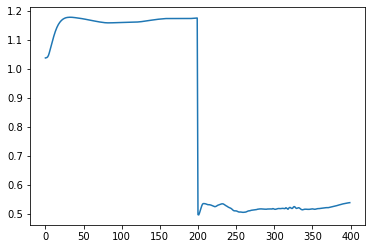

In [97]:

plt.plot(ld)
plt.savefig('../Expirements/SavedTransforms/0-13_reindex_weak_hp/report/latent_dist_2.png')
plt.show()

## Plots

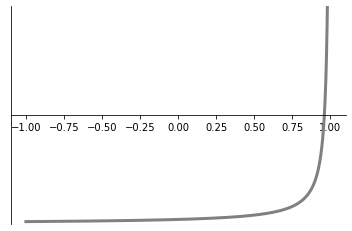

In [156]:
import math
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a


x = np.array([c / 1000 for c in range(0, 1000)])
y = 1 / (1 - x)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
#ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.plot(x,y, color='grey', linewidth=3)
plt.yticks([])  
plt.ylim((-0, 50))
plt.savefig("Expirements/Visualizations/Paper/sdfnondiff.pdf")
plt.show()